# Imblanced Data Challenge

### Challenge:
The motive of this imbalanced data challenge is to identify the imbalanced data problems and tackle them using class weighting and resampling methods in the following datasets:
    
    1.Credit Card Fraud Detection
    
    2.Predicting Customer Churn
    
    3.Predicting Job Change

### Objective:

    1. To apply Class Re-weighting method to adjust the impacts of different classes in model training processes.
    
    2.To apply Oversampling and Undersampling to generate synthetic datasets and rebalance classes.
    
    3.To evaluate the consolidated classifiers using robust metrics such as F-score and AUC.

###### Importing the packages:

In [1]:
import pandas as pd
import numpy as np 
import imblearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# 1.Credit Card Fraud Detection

In [2]:
credit_df = pd.read_csv("creditcard.csv")

In [3]:
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit_df["Class"].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

<AxesSubplot:>

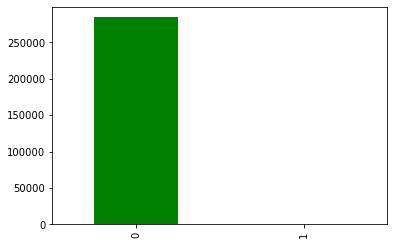

In [5]:
credit_df["Class"].value_counts().plot(kind='bar', color=['green', 'red'])

In this dataset the class-0 represents safe transaction while the class-1 represents fraud transaction.

From the bar chart it can be observed that the dataset is extremely imbalanced where the dataset have only about 0.001% fraud transaction data.

Let's build a standard Logistic Regression model see how it performs on imbalanced dataset.

In [6]:
X = credit_df.iloc[:,:-1]
y = credit_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state =10)

In [7]:
lr =LogisticRegression(max_iter =1000)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

In [8]:
def evaluate_metrics(yt,y_pr):
    return pd.Series({'accuracy':accuracy_score(yt, y_pr),
                      'precision':precision_score(yt, y_pr),
                      'recall':recall_score(yt,y_pr),
                      'f1_score':f1_score(yt, y_pr),
                       'auc': roc_auc_score(yt, y_pr)},
                      ).to_frame()

In [9]:
evaluate_metrics(y_test, pred)

,0
accuracy,0.999245
precision,0.848101
recall,0.683673
f1_score,0.757062
auc,0.841731


Here the accuracy is 0.999

For many machine learning tasks on imbalanced datasets, like credit card fraud detection, we want the model to be able to find all frauds and we would allow the model to make false-positive errors because the cost of false positives is usually not very high  On the other hand, failing to recognize positive examples is not better.

Hence our priority is to improve the model's recall, then we will also want to keep precision as high as possible.

## SMOTE - Synthetic Minority Oversampling Technique

SMOTE first creates many pairs or small clusters with two or more similar instances, the measure by instance distance such as Euclidean distance. Then, within the boundary of each pair or cluster, SMOTE uniformly permutes features value, one feature at a time, to populate a collection of similar synthesized instances within each pair or cluster.

As a result, SMOTE creates a class-balanced synthetic dataset without adding duplicated instances with minority labels.

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
smote =SMOTE(random_state=10)

In [12]:
X_smote, y_smote = smote.fit_resample(X_train, y_train)

<AxesSubplot:>

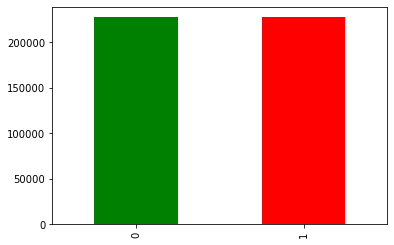

In [13]:
y_smote.value_counts().plot.bar(color=['green', 'red'])

After SMOTE resampling, we can see both positive and negative class has the same instances

Let's retrain the logistic regression model with resampled training data using SMOTE

In [14]:
lr.fit(X_smote, y_smote)
pred_smote = lr.predict(X_test)

Calculating the evaluation metrics

In [15]:
evaluate_metrics(y_test, pred_smote)

,0
accuracy,0.990099
precision,0.132492
recall,0.857143
f1_score,0.229508
auc,0.923735


The SMOTE improves the auc from 0.8417 to 0.9237 and improves recall from 0.6836 to 0.8571 but it does not perform well for the precision. 

The reason for the bad precision might be extremely skewed dataset

Now let's try class reweighting to the same dataset

## Class Reweighting

Since the class distribution is skewed in imbalanced datasets and the loss function optimization process will be dominated by the majority class, we want to help the minority class by increasing its class weight in the loss function.

In [16]:
class_weight = {}
class_weight[0] = 0.1
class_weight[1] = 0.9

Here the minority class-1 is given a weight of 0.9

In [17]:
lr_cw = LogisticRegression(max_iter = 1000, class_weight=class_weight)

In [18]:
lr_cw.fit(X_train, y_train)
pred_cw = lr_cw.predict(X_test)

In [19]:
evaluate_metrics(y_test, pred_cw)

,0
accuracy,0.999175
precision,0.742857
recall,0.795918
f1_score,0.768473
auc,0.897722


Here the model gives much balanced precision and recall values. thus Class reweighting works better than SMOTE in credit card fraud detection which is extremely imbalanced.

### Findings from the credit card fraud detection task:

1.SMOTE can achieve high recall but extremely low precision due to the caused disruptions of original data distribution.

2.Class reweighting can achieve a more balanced recall and precision value.

# 2.Predicting Customer Churn

In [22]:
churn_df = pd.read_csv("im_churn.csv")

In [23]:
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [24]:
X = churn_df.iloc[:,:-1]
y = churn_df['Class']
X_trainccp,X_testccp, y_trainccp, y_testccp = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 10)

In [25]:
y_testccp.value_counts(normalize= True)

0    0.838057
1    0.161943
Name: Class, dtype: float64

<AxesSubplot:>

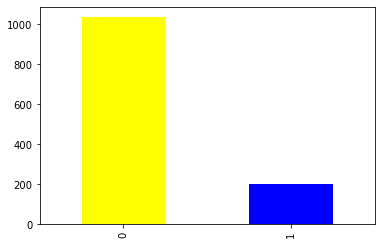

In [26]:
y_testccp.value_counts().plot(kind='bar', color=['yellow', 'blue'])

From the chart it can be infered that the dataset is unbalanced, where class-0 represents non churned customers and class-1 represents churned customers.

For the customer churning dataset we shall use RandomForestClasssifier

Now let's tune the parameters and find the best params using GridSearchCV

In [27]:
params_grid = {
    'n_estimators':[25,50,100],
    'max_depth':[5,10,15,20],
    'min_samples_split':[2,5]
}

In [28]:
rfc = RandomForestClassifier()
grid_search =GridSearchCV(estimator = rfc, param_grid = params_grid, scoring='f1', cv = 5, verbose = 2)

In [29]:
grid_search.fit(X_trainccp, y_trainccp)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_split=2, n_e

[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=25; total time=   0.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=25; total time=   0.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=25; total time=   0.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=25; total time=   0.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=25; total time=   0.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [25, 50, 100]},
             scoring='f1', verbose=2)

In [30]:
best_params = grid_search.best_params_
best_params

{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 25}

In [31]:
results=[]

In [32]:
def evaluate(yt, yp, eval_type):
    results = {}
    results['type'] = eval_type
    results['accuracy'] = accuracy_score(yt, yp)
    results['recall'] = recall_score(yt, yp)
    results['auc'] = roc_auc_score(yt, yp)
    results['precision'] = precision_score(yt, yp)
    results['f1_score'] = f1_score(yt, yp)
    return results

##### Training a regular random forest classifier

from the best parameters found :

In [33]:
rfc = RandomForestClassifier(random_state= 10, max_depth = 20, n_estimators = 25, min_samples_split = 2)

In [34]:
rfc.fit(X_trainccp, y_trainccp)

RandomForestClassifier(max_depth=20, n_estimators=25, random_state=10)

In [35]:
rfc_pred = rfc.predict(X_testccp)

In [36]:
evaluate_metrics(y_testccp, rfc_pred)

,0
accuracy,0.859919
precision,0.609756
recall,0.375000
f1_score,0.464396
auc,0.664312


In [37]:
result1 = evaluate(y_testccp, rfc_pred, 'Original')
results.append(result1)
results

[{'type': 'Original',
  'accuracy': 0.8599190283400809,
  'recall': 0.375,
  'auc': 0.6643115942028985,
  'precision': 0.6097560975609756,
  'f1_score': 0.46439628482972134}]

## Class reweighting

In [38]:
class_weight = {}
class_weight[0] = 0.1
class_weight[1] = 0.9

The class-0 non churning has given weight of 0.2 and the class-1 churning customer has given weight of 0.8

In [39]:
rfc_cw = RandomForestClassifier(random_state= 10, class_weight=class_weight, max_depth = 10, n_estimators = 50, min_samples_split = 5)

In [40]:
rfc_cw.fit(X_trainccp, y_trainccp)

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       min_samples_split=5, n_estimators=50, random_state=10)

In [41]:
rfc_cw_pred = rfc_cw.predict(X_testccp)
evaluate_metrics(y_testccp, rfc_cw_pred)

,0
accuracy,0.795142
precision,0.427793
recall,0.785000
f1_score,0.553792
auc,0.791051


In [42]:
result2 = evaluate(y_testccp, rfc_cw_pred, 'Class Weight')
results.append(result2)
results

[{'type': 'Original',
  'accuracy': 0.8599190283400809,
  'recall': 0.375,
  'auc': 0.6643115942028985,
  'precision': 0.6097560975609756,
  'f1_score': 0.46439628482972134},
 {'type': 'Class Weight',
  'accuracy': 0.7951417004048583,
  'recall': 0.785,
  'auc': 0.7910507246376812,
  'precision': 0.42779291553133514,
  'f1_score': 0.5537918871252204}]

Hence adding class weights Recall and FScore has been improved significantly

Now shall perform SMOTE and Undersampling to see if it performs well

## SMOTE

In [43]:
smote_ccp = SMOTE()
X_smote_ccp, y_smote_ccp = smote_ccp.fit_resample(X_trainccp, y_trainccp)

Performing RandomForestClassifier on the SMOTE resampled dataset.

In [44]:
rfc_smote = RandomForestClassifier(random_state= 10, max_depth = 20, n_estimators = 25, min_samples_split = 2)
rfc_smote.fit(X_smote_ccp, y_smote_ccp)
pred_rfc_smote = rfc_smote.predict(X_testccp)
evaluate_metrics( y_testccp, pred_rfc_smote)

,0
accuracy,0.842105
precision,0.516129
recall,0.400000
f1_score,0.450704
auc,0.663768


In [45]:
result3 = evaluate(y_testccp, pred_rfc_smote, 'SMOTE')
results.append(result3)

## UnderSampling

In [46]:
from imblearn.under_sampling import RandomUnderSampler

In [47]:
under_sampler = RandomUnderSampler(random_state=10)
X_under_ccp, y_under_ccp = under_sampler.fit_resample(X_trainccp, y_trainccp)

In [48]:
rfc_under = RandomForestClassifier(random_state= 10, max_depth = 20, n_estimators = 25, min_samples_split = 2)

In [49]:
rfc_under.fit(X_under_ccp, y_under_ccp)
pred_under = rfc_under.predict(X_testccp)

In [50]:
evaluate_metrics( y_testccp, pred_under)


,0
accuracy,0.757895
precision,0.382979
recall,0.810000
f1_score,0.520064
auc,0.778913


In [51]:
result = evaluate(y_testccp, pred_under, 'Undersampling')
results.append(result)

In [52]:
df = pd.DataFrame(data=results)

In [53]:
df

,type,accuracy,recall,auc,precision,f1_score
0,Original,0.859919,0.375,0.664312,0.609756,0.464396
1,Class Weight,0.795142,0.785,0.791051,0.427793,0.553792
2,SMOTE,0.842105,0.400,0.663768,0.516129,0.450704
3,Undersampling,0.757895,0.810,0.778913,0.382979,0.520064


To analyze and compare performance among different methos of resampling performed on the random forest classifier, plot them in the grouped bar chart.

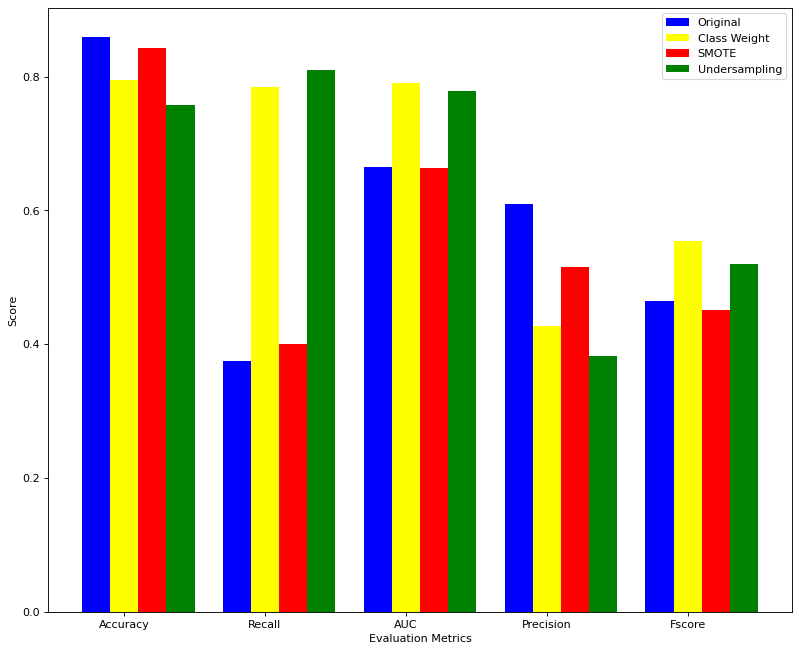

In [54]:
x = np.arange(5)
original = df.iloc[0, 1:].values
class_weight = df.iloc[1, 1:].values
smote = df.iloc[2, 1:].values
under = df.iloc[3, 1:].values
plt.figure(figsize=(12, 10), dpi=80)
plt.bar(x-0.2, original, width = 0.2, color='blue')
plt.bar(x, class_weight, width = 0.2, color='yellow')
plt.bar(x+0.2, smote, width = 0.2, color='red')
plt.bar(x+0.4, under, width = 0.2, color='green')
plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
plt.show()

In the chart,

    The blue bars represent the original model,
    
    The yellow bars represent the model with class weight, 
    
    The red bars represent model trained with SMOTE,
    
    The green bars represent the model trained with undersampling.

### Insights from the bar charts:

    1.All models have high accuracy.
    
    2.Recall is improved with class weights aand undersampling.
    
    3.AUC is also improved with class weights and undersampling.

    4.Precisions are decreased with class weights and resampling methods as they all introduced many false positives.
    
    5.Fscore is improved with class weights and undersampling.

By analyzing the bar chart above, we can see that undersampling seems to be the best method for the imbalanced challenge in the customer churn dataset.

## 3.Predicting Job change

In [61]:
job_df = pd.read_csv("im_hr.csv", index_col=False)

In [62]:
job_df.head()

,city_development_index,training_hours,company_size,experience,relevent_experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,gender_Female,gender_Male,gender_Other,Class
0,0.920,61.0,3.0,15.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.802,156.0,3.0,15.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.920,126.0,2.0,21.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.910,50.0,4.0,10.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.913,42.0,0.0,21.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [63]:
X_job = job_df.iloc[:,:-1]
y_job = job_df['Class'].astype('int')

In [64]:
X_job.shape

(15781, 15)

In [65]:
y_job.shape

(15781,)

<AxesSubplot:>

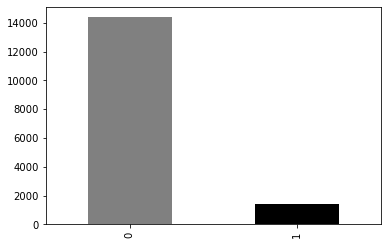

In [66]:
y_job.value_counts().plot.bar(color=['grey','black'])

In [67]:
y_job.value_counts(normalize=True)

0    0.911286
1    0.088714
Name: Class, dtype: float64

The dataset is extremely imbalanced that the class-1 representing the job change factor is only about 8% of data.

In [72]:
X_job_train, X_job_test, y_job_train, y_job_test = train_test_split(X_job, y_job, stratify=y_job, random_state = 10, test_size=0.2)

##### Logistic regression model with the original dataset

In [73]:
lr_jc = LogisticRegression(max_iter=1000, random_state=10)
lr_jc.fit(X_job_train, y_job_train)

LogisticRegression(max_iter=1000, random_state=10)

In [74]:
pred_jc = lr_jc.predict(X_job_test)

In [75]:
evaluate_metrics(y_job_test, pred_jc)

C:\Users\sundh\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0
accuracy,0.911308
precision,0.000000
recall,0.000000
f1_score,0.000000
auc,0.500000


In [76]:
results=[]

In [77]:
result = evaluate(y_job_test, pred_jc, 'Original')
results.append(result)

C:\Users\sundh\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Class Weighting

In [78]:
class_weight={}
class_weight[0]=0.1
class_weight[1]=0.9

In [79]:
lr_jc_cw = LogisticRegression(max_iter=1000, random_state=10, penalty='l2', class_weight=class_weight)
lr_jc_cw.fit(X_job_train, y_job_train)

LogisticRegression(class_weight={0: 0.1, 1: 0.9}, max_iter=1000,
                   random_state=10)

In [80]:
pred_jc_cw = lr_jc_cw.predict(X_job_test)

In [81]:
evaluate_metrics(y_job_test, pred_jc_cw)

,0
accuracy,0.751663
precision,0.197115
recall,0.585714
f1_score,0.294964
auc,0.676764


In [82]:
result = evaluate(y_job_test, pred_jc_cw, 'Class Reweighting')
results.append(result)

In [83]:
results

[{'type': 'Original',
  'accuracy': 0.9113082039911308,
  'recall': 0.0,
  'auc': 0.5,
  'precision': 0.0,
  'f1_score': 0.0},
 {'type': 'Class Reweighting',
  'accuracy': 0.7516629711751663,
  'recall': 0.5857142857142857,
  'auc': 0.6767639902676401,
  'precision': 0.1971153846153846,
  'f1_score': 0.2949640287769784}]

### SMOTE

In [84]:
smote_jc = SMOTE()

In [85]:
X_jc_smote, y_jc_smote = smote_jc.fit_resample(X_job_train, y_job_train)

<AxesSubplot:>

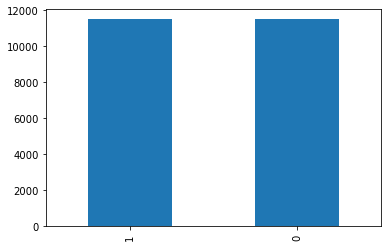

In [86]:
y_jc_smote.value_counts().plot.bar()

In [87]:
lr_smote = LogisticRegression(max_iter=1000, random_state=10, penalty='l2')
lr_smote.fit(X_jc_smote, y_jc_smote)

LogisticRegression(max_iter=1000, random_state=10)

In [88]:
pred_jc_smote = lr_smote.predict(X_job_test)

In [89]:
evaluate_metrics(y_job_test, pred_jc_smote)

,0
accuracy,0.727589
precision,0.187500
recall,0.621429
f1_score,0.288079
auc,0.679675


In [90]:
result = evaluate(y_job_test, pred_jc_smote, 'Smote')
results.append(result)

In [91]:
results

[{'type': 'Original',
  'accuracy': 0.9113082039911308,
  'recall': 0.0,
  'auc': 0.5,
  'precision': 0.0,
  'f1_score': 0.0},
 {'type': 'Class Reweighting',
  'accuracy': 0.7516629711751663,
  'recall': 0.5857142857142857,
  'auc': 0.6767639902676401,
  'precision': 0.1971153846153846,
  'f1_score': 0.2949640287769784},
 {'type': 'Smote',
  'accuracy': 0.7275894836870447,
  'recall': 0.6214285714285714,
  'auc': 0.6796750086896072,
  'precision': 0.1875,
  'f1_score': 0.2880794701986755}]

### Undersampling

In [92]:
under_sampler = RandomUnderSampler(random_state=10)
X_under_job, y_under_job = under_sampler.fit_resample(X_job_train, y_job_train)

In [93]:
lr_under = LogisticRegression(max_iter=1000, random_state=10, penalty='l2')
lr_under.fit(X_under_job, y_under_job)

LogisticRegression(max_iter=1000, random_state=10)

In [94]:
pred_jc_under = lr_under.predict(X_job_test)

In [95]:
evaluate_metrics(y_job_test, pred_jc_under)

,0
accuracy,0.716186
precision,0.186354
recall,0.653571
f1_score,0.290016
auc,0.687926


In [96]:
result = evaluate(y_job_test, pred_jc_under, 'Undersampling')
results.append(result)

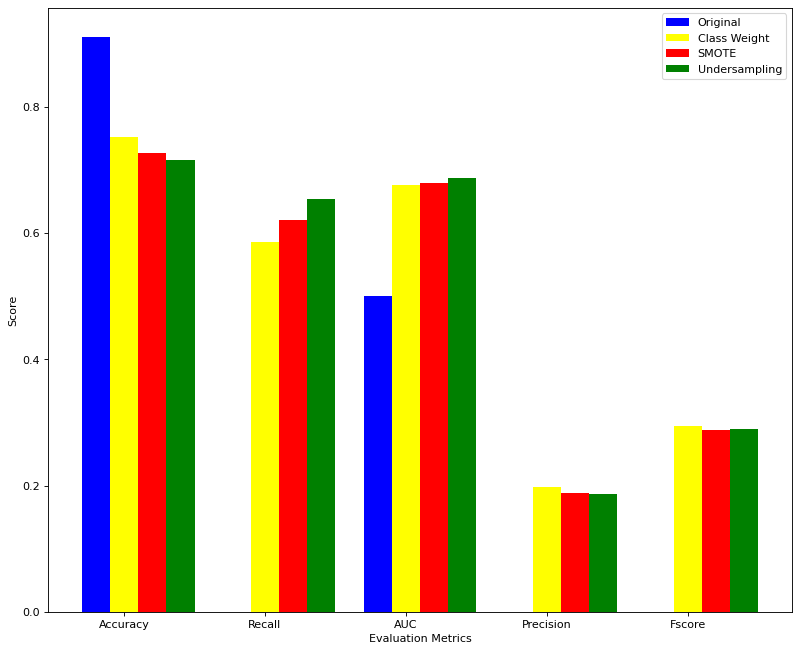

In [97]:
df = pd.DataFrame(data=results)
x = np.arange(5)
original = df.iloc[0, 1:].values
class_weight = df.iloc[1, 1:].values
smote = df.iloc[2, 1:].values
under = df.iloc[3, 1:].values
plt.figure(figsize=(12, 10), dpi=80)
plt.bar(x-0.2, original, width = 0.2, color='blue')
plt.bar(x, class_weight, width = 0.2, color='yellow')
plt.bar(x+0.2, smote, width = 0.2, color='red')
plt.bar(x+0.4, under, width = 0.2, color='green')
plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
plt.show()